# Data Processing - Sentiment Analysis

## Setup & Load data

In [ ]:
'''
!pip install torch transformers pandas
'''

'\n!pip install torch transformers pandas\n'

In [ ]:
# Download lyric json file

'''
%cd /content
!gdown --id '1xui4iENOPyYtz-xdUpNMwQml9G-q2TlT' --output all_song_lyrics_dict_cleaned.json
'''

/content
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1xui4iENOPyYtz-xdUpNMwQml9G-q2TlT
From (redirected): https://drive.google.com/uc?id=1xui4iENOPyYtz-xdUpNMwQml9G-q2TlT&confirm=t&uuid=31bb200f-97e1-40d9-8dec-6f2ead498687
To: /content/all_song_lyrics_dict_cleaned.json
100% 312M/312M [00:08<00:00, 35.0MB/s]


In [ ]:
import json
import pandas as pd

with open('all_song_lyrics_dict_cleaned.json', 'r') as json_file:
    all_song_lyrics_dict_cleaned = json.load(json_file)


def get_lyrics(song, artist, dict=all_song_lyrics_dict_cleaned):
    '''
    Return lyrics from the lyrics dictionary.
    '''
    song_artist = song + ' - ' + artist
    if song_artist in dict.keys():
        return dict[song_artist]

In [ ]:
df = pd.DataFrame.from_dict(all_song_lyrics_dict_cleaned, orient='index').reset_index()

df.head()

,index,0
0,Glory - Common & John Legend,\n\nOne day when the glory comes\nIt will be o...
1,Glory And Gore - Lorde,\n\nThere's a humming in the restless summer a...
2,Glory Bound - The Grass Roots,All the sun on the outside\nDoesn't touch what...
3,Glory Days - Bruce Springsteen,\n\nOh yeah\nC'mon\nWooh\nHuh\n\nI had a frien...
4,Glory Glory - The Rascals,"I saw a child, he was carryin' a light\nI aske..."


In [ ]:
df.columns = ['song - artist', 'lyrics']

df.head()

,song - artist,lyrics
0,Glory - Common & John Legend,\n\nOne day when the glory comes\nIt will be o...
1,Glory And Gore - Lorde,\n\nThere's a humming in the restless summer a...
2,Glory Bound - The Grass Roots,All the sun on the outside\nDoesn't touch what...
3,Glory Days - Bruce Springsteen,\n\nOh yeah\nC'mon\nWooh\nHuh\n\nI had a frien...
4,Glory Glory - The Rascals,"I saw a child, he was carryin' a light\nI aske..."


In [ ]:
# Basic preprocessing

df['lyrics'] = df['lyrics'].str.replace(r'\n', ' ')  # Replace new lines with spaces - omit it if using third method
df['lyrics'] = df['lyrics'].str.lower()  # Lowercase the lyrics for consistency

df.head()

<ipython-input-5-7a3fac9596f7>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['lyrics'] = df['lyrics'].str.replace(r'\n', ' ')  # Replace new lines with spaces - omit it if using third method


,song - artist,lyrics
0,Glory - Common & John Legend,one day when the glory comes it will be ours...
1,Glory And Gore - Lorde,there's a humming in the restless summer air...
2,Glory Bound - The Grass Roots,all the sun on the outside doesn't touch what ...
3,Glory Days - Bruce Springsteen,oh yeah c'mon wooh huh i had a friend was a...
4,Glory Glory - The Rascals,"i saw a child, he was carryin' a light i asked..."


In [ ]:
from transformers import pipeline, BertTokenizer
import numpy as np

# Load tokenizer and sentiment analysis pipeline
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
sentiment_pipeline = pipeline("sentiment-analysis")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

## Use chunk to overcome token-limit challenge

In [ ]:
def chunk_text(text, max_length=508):
    '''
    First chunk method: take all text in the lyrcis: 35 min for 1 batch out of 31
    '''
    tokens = tokenizer.tokenize(text)
    chunks = []
    chunk = []
    for i, token in enumerate(tokens):
        chunk.append(token)
        if len(chunk) == max_length - 2 or i == len(tokens) - 1:
            chunks.append(tokenizer.convert_tokens_to_string(chunk))
            chunk = []
    return chunks

In [ ]:
def chunk_text(text, max_length=508):
    '''
    Second chunk method: take both 254 words from head and tail: 8 min for 1 batch out of 31    
    '''
    # Tokenize the entire text
    tokens = tokenizer.tokenize(text)

    # Calculate the number of tokens to select from the beginning and the end
    half_max_length = max_length // 2

    # Select the first and last portions of the tokens
    if len(tokens) > max_length:
        beginning_tokens = tokens[:half_max_length]
        end_tokens = tokens[-half_max_length:]
    else:
        beginning_tokens = tokens
        end_tokens = []

    # Convert tokens back to strings
    beginning_chunk = tokenizer.convert_tokens_to_string(beginning_tokens)
    end_chunk = tokenizer.convert_tokens_to_string(end_tokens) if end_tokens else ''

    # Combine the two chunks into a list, omitting the end chunk if it's empty
    chunks = [beginning_chunk, end_chunk] if end_chunk else [beginning_chunk]

    return chunks

In [ ]:
# To use this method, reload the data and keep '\n' in lyrics
import random

def chunk_text(text, max_length=508):
    '''
    Third chunk method: pick random lines in lyrics: 6 min for 1 batch out of 31
    '''
    # Split the text into lines
    lines = text.split('\n')

    # Shuffle the lines randomly
    random.shuffle(lines)

    # Initialize variables for chunk creation
    chunk_tokens = []
    chunk = ''

    # Iterate through the shuffled lines
    for line in lines:
        line_tokens = tokenizer.tokenize(line)
        # Check if adding the current line would exceed the max_length
        if len(chunk_tokens) + len(line_tokens) <= max_length:
            chunk_tokens.extend(line_tokens)
            # Add a space before the line if the chunk is not empty
            chunk += (' ' + line if chunk else line)
        else:
            # Stop adding lines if the next one would exceed the limit
            break

    # Return the chunk as a string
    return chunk

## Examine different chunk method

### Compare M1, M2 and M3

In [4]:
import pandas as pd

# Load the CSV files into DataFrames
df_m1 = pd.read_csv('lyrics_sentiment_batch_1_m1.csv')
df_m2 = pd.read_csv('lyrics_sentiment_batch_1_m2.csv')
df_m3 = pd.read_csv('lyrics_sentiment_batch_1_m3.csv')

# Display the first few rows of each DataFrame to understand their structure
df_m1.head()

,song - artist,lyrics,average_positive,average_negative
0,Glory - Common & John Legend,one day when the glory comes it will be ours...,0.655919,0.000000
1,Glory And Gore - Lorde,there's a humming in the restless summer air...,0.000000,0.010337
2,Glory Bound - The Grass Roots,all the sun on the outside doesn't touch what ...,0.985848,0.000000
3,Glory Days - Bruce Springsteen,oh yeah c'mon wooh huh i had a friend was a...,0.130273,0.014129
4,Glory Glory - The Rascals,"i saw a child, he was carryin' a light i asked...",0.987065,0.000000


In [5]:
df_m2.head()

,song - artist,lyrics,average_positive,average_negative
0,Glory - Common & John Legend,one day when the glory comes it will be ours...,0.491604,0.036153
1,Glory And Gore - Lorde,there's a humming in the restless summer air...,0.337827,0.004051
2,Glory Bound - The Grass Roots,all the sun on the outside doesn't touch what ...,0.985848,0.000000
3,Glory Days - Bruce Springsteen,oh yeah c'mon wooh huh i had a friend was a...,0.493888,0.006323
4,Glory Glory - The Rascals,"i saw a child, he was carryin' a light i asked...",0.987065,0.000000


In [6]:
df_m3.head()

,song - artist,lyrics,average_positive,average_negative
0,Glory - Common & John Legend,\n\none day when the glory comes\nit will be o...,0.000611,0.000000
1,Glory And Gore - Lorde,\n\nthere's a humming in the restless summer a...,0.000000,0.000046
2,Glory Bound - The Grass Roots,all the sun on the outside\ndoesn't touch what...,0.001229,0.000000
3,Glory Days - Bruce Springsteen,\n\noh yeah\nc'mon\nwooh\nhuh\n\ni had a frien...,0.000000,0.000084
4,Glory Glory - The Rascals,"i saw a child, he was carryin' a light\ni aske...",0.001505,0.000000


In [7]:
# Merge the DataFrames on the 'song - artist' column
df_merged = df_m1.merge(df_m2, on='song - artist', suffixes=('_m1', '_m2'))
df_merged = df_merged.merge(df_m3, on='song - artist')
df_merged.rename(columns={'average_positive': 'average_positive_m3', 'average_negative': 'average_negative_m3'}, inplace=True)

# Calculate statistical measures for each method's sentiment scores
statistics_m1 = df_merged[['average_positive_m1', 'average_negative_m1']].describe()
statistics_m2 = df_merged[['average_positive_m2', 'average_negative_m2']].describe()
statistics_m3 = df_merged[['average_positive_m3', 'average_negative_m3']].describe()

(statistics_m1, statistics_m2, statistics_m3)

(       average_positive_m1  average_negative_m1
 count          1000.000000          1000.000000
 mean              0.411725             0.023925
 std               0.458059             0.061519
 min               0.000000             0.000000
 25%               0.000000             0.000000
 50%               0.064420             0.002202
 75%               0.987442             0.016163
 max               0.999866             0.484324,
        average_positive_m2  average_negative_m2
 count          1000.000000          1000.000000
 mean              0.440639             0.024550
 std               0.459108             0.063294
 min               0.000000             0.000000
 25%               0.000000             0.000000
 50%               0.327358             0.001652
 75%               0.989390             0.013268
 max               0.999866             0.484324,
        average_positive_m3  average_negative_m3
 count           998.000000           998.000000
 mean             

From this, we can observe:
+ Method 1 and Method 2 have higher average positive and negative scores than Method 3, with Method 2 having slightly higher means than Method 1.
  
+ Method 3 has significantly lower scores on average, suggesting that the sampling strategy used in this method results in much lower sentiment scores.
  
+ The standard deviation in Methods 1 and 2 is similar and quite high, indicating a wide distribution of sentiment scores across the songs. Method 3's standard deviation is very low, reflecting the very small range of sentiment scores produced by this method.

### Compare M1 and M2

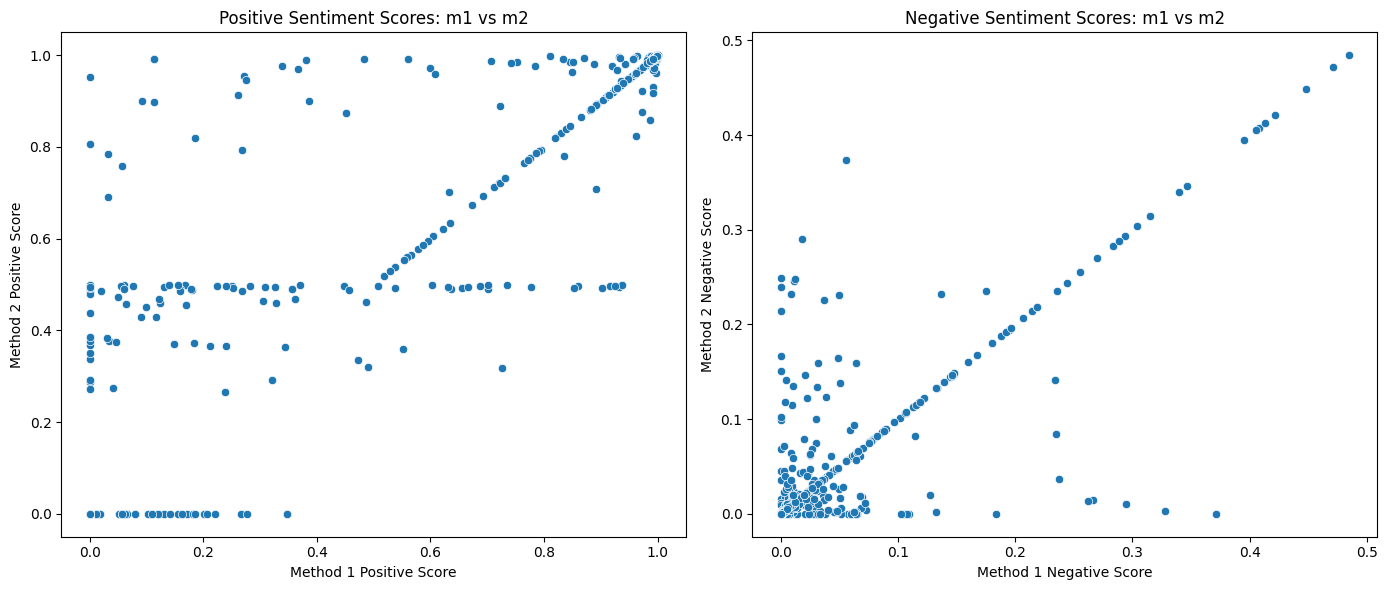

(0.9483503797057309,
 0.7984577787178424,
 TtestResult(statistic=-6.203336925793834, pvalue=8.083397119151102e-10, df=999),
 TtestResult(statistic=-0.49882289795760043, pvalue=0.6180139703220588, df=999))

In [8]:
from scipy.stats import ttest_rel
import seaborn as sns
import matplotlib.pyplot as plt

# Direct Score Comparison
df_merged['positive_diff'] = df_merged['average_positive_m1'] - df_merged['average_positive_m2']
df_merged['negative_diff'] = df_merged['average_negative_m1'] - df_merged['average_negative_m2']

# Correlation
correlation_positive = df_merged['average_positive_m1'].corr(df_merged['average_positive_m2'])
correlation_negative = df_merged['average_negative_m1'].corr(df_merged['average_negative_m2'])

# Paired t-test
ttest_positive = ttest_rel(df_merged['average_positive_m1'], df_merged['average_positive_m2'])
ttest_negative = ttest_rel(df_merged['average_negative_m1'], df_merged['average_negative_m2'])

# Visualization - Scatter plots
plt.figure(figsize=(14, 6))

# Positive Sentiment Scores
plt.subplot(1, 2, 1)
sns.scatterplot(x='average_positive_m1', y='average_positive_m2', data=df_merged)
plt.title('Positive Sentiment Scores: m1 vs m2')
plt.xlabel('Method 1 Positive Score')
plt.ylabel('Method 2 Positive Score')

# Negative Sentiment Scores
plt.subplot(1, 2, 2)
sns.scatterplot(x='average_negative_m1', y='average_negative_m2', data=df_merged)
plt.title('Negative Sentiment Scores: m1 vs m2')
plt.xlabel('Method 1 Negative Score')
plt.ylabel('Method 2 Negative Score')

plt.tight_layout()
plt.show()

(correlation_positive, correlation_negative, ttest_positive, ttest_negative)

The detailed comparison between Method 1 (m1) and Method 2 (m2) reveals the following:

+ Correlation:
  + Positive Scores: The correlation coefficient between the positive scores given by m1 and m2 is very high at approximately 0.948, indicating a strong positive relationship.
  + Negative Scores: The correlation for negative scores is lower but still substantial at approximately 0.798, indicating a generally strong agreement between the two methods.

+ Paired t-test:
  + Positive Scores: The paired t-test for positive scores shows a statistically significant difference (p-value ≈ 8.08e-10), with a t-statistic of approximately -6.20. This suggests that the positive scores between m1 and m2 are significantly different.
  + Negative Scores: For negative scores, the paired t-test shows no statistically significant difference (p-value ≈ 0.618), with a t-statistic of approximately -0.499. This implies that any differences in negative scores between the methods could be due to chance.

+ Visualization:
  + The scatter plot for positive sentiment scores shows a tight cluster along the line y = x, which indicates that the scores from both methods are quite similar, but there are some deviations as the spread increases with higher scores.
  + The scatter plot for negative sentiment scores is also clustered around the line y = x but with more spread, especially for lower scores, reflecting the variability captured by the correlation coefficient and the paired t-test.

Considering all these factors and the operating efficiency, we finally choose Method 2 to chunk our lyrics for further processing.

## Do sentiment analysis with the second method

In [ ]:
def analyze_sentiment_separate(text_chunks):
    '''
    Do separate sentiment analysis with chunks
    '''
    results = sentiment_pipeline(text_chunks)

    # Initialize variables to hold weighted sums and total lengths
    positive_weighted_sum = 0
    negative_weighted_sum = 0
    total_length = 0

    # Calculate total length for weighting
    for chunk in text_chunks:
        total_length += len(tokenizer.tokenize(chunk))

    # Iterate through results and categorize scores with weights
    for chunk, result in zip(text_chunks, results):
        chunk_length = len(tokenizer.tokenize(chunk))
        if total_length == 0:
          # Handle the zero total_length case, e.g., by continuing to the next iteration
          weight = 0
        else:
          weight = chunk_length / total_length  # Calculate weight for the current chunk

        if result['label'] == 'POSITIVE':
            positive_weighted_sum += result['score'] * weight
        else:
            # Transforming score to maintain consistency and applying weight
            negative_weighted_sum += (1 - result['score']) * weight

    # Calculate weighted averages
    if total_length > 0:  # Ensure division by zero does not occur
        average_positive = positive_weighted_sum
        average_negative = negative_weighted_sum
    else:
        average_positive, average_negative = None, None

    return average_positive, average_negative


"\ndef analyze_sentiment(text_chunks):\n    results = sentiment_pipeline(text_chunks)\n    scores = [result['score'] if result['label'] == 'POSITIVE' else 1 - result['score'] for result in results]\n    average_score = np.mean(scores)\n    return average_score\n"

In [ ]:
# Before run this block, REMEMBER to run the code of the second method "process_lyrics_sentiment_separate" function!

def process_in_batches(df, start_batch, batch_size=1000):
    '''
    Do batch processing for the sentiment analysis to avoid data loss due to breakdown
    '''
    # Number of batches
    num_batches = len(df) // batch_size + (1 if len(df) % batch_size else 0)

    for i in range(start_batch-1, num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        print(f"Processing batch {i+1}/{num_batches} (records {start_idx} to {end_idx})")

        # Apply the sentiment analysis function to the batch
        batch_results = df.iloc[start_idx:end_idx].apply(lambda row: process_lyrics_sentiment_separate(row), axis=1, result_type='expand')

        # Correct assignment to df
        df.loc[start_idx:end_idx-1, ['average_positive', 'average_negative']] = batch_results.values # Use .values to assign correctly

        # Save the batch results to a CSV file
        batch_df = df.iloc[start_idx:end_idx]
        batch_df.to_csv(f'lyrics_sentiment_batch_{i+1}.csv', index=False)

        print(f"Saved batch {i+1} to CSV")

    return df


def process_lyrics_sentiment_separate(row):
    '''
    Do sentiment analysis for each row in the record
    '''
    text_chunks = chunk_text(row['lyrics'])
    if not text_chunks:
        return None, None
    return analyze_sentiment_separate(text_chunks)

In [ ]:
# Process in batches to avoid data loss - it crashed once, so I changed the start_batch from 0 to 11 to continue
df = process_in_batches(df, 11)

Processing batch 11/31 (records 10000 to 11000)
Saved batch 11 to CSV
Processing batch 12/31 (records 11000 to 12000)
Saved batch 12 to CSV
Processing batch 13/31 (records 12000 to 13000)
Saved batch 13 to CSV
Processing batch 14/31 (records 13000 to 14000)
Saved batch 14 to CSV
Processing batch 15/31 (records 14000 to 15000)
Saved batch 15 to CSV
Processing batch 16/31 (records 15000 to 16000)
Saved batch 16 to CSV
Processing batch 17/31 (records 16000 to 17000)
Saved batch 17 to CSV
Processing batch 18/31 (records 17000 to 18000)
Saved batch 18 to CSV
Processing batch 19/31 (records 18000 to 19000)
Saved batch 19 to CSV
Processing batch 20/31 (records 19000 to 20000)
Saved batch 20 to CSV
Processing batch 21/31 (records 20000 to 21000)
Saved batch 21 to CSV
Processing batch 22/31 (records 21000 to 22000)
Saved batch 22 to CSV
Processing batch 23/31 (records 22000 to 23000)
Saved batch 23 to CSV
Processing batch 24/31 (records 23000 to 24000)
Saved batch 24 to CSV
Processing batch 25/

In [ ]:
# Save to CSV

df.to_csv('lyrics_with_separate_sentiment_scores.csv', index=False)

"\ndf.to_csv('lyrics_with_sentiment_scores.csv', index=False)\n"